Model Resuspension Check

In [1]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *

import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]
#
path_months = '/results2/SalishSea/month-avg.202111/'
path_days_h = '/results2/SalishSea/nowcast-green.202111/'

In [3]:
def monthly_prefix(date, path, area='biol_T_'):
    #
    prefix = os.path.join(path, f'SalishSeaCast_1m_{area}{date.strftime("%Y%m%d").lower()}*')
    file_name = glob.glob(prefix) 
    #
    return file_name

In [4]:
def hourly_prefix(date, path, area='biol_T_'):
    #
    prefix = os.path.join(path, f'SalishSeaCast_1m_{area}{date.strftime("%Y%m%d").lower()}*')
    file_name = glob.glob(prefix) 
    #
    return file_name

Getting the data files for August 06, 2015 - March 10, 2016

In [5]:
def date_files(date, path, prefix_type= 'grid_T.nc'):
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, folder + f'/SalishSea_1h_{date.strftime("%Y%m%d").lower()}_{date.strftime("%Y%m%d").lower()}_{prefix_type}*')
    file_name = glob.glob(prefix) 
    return file_name

In [6]:
path = '/ocean/sallen/timbucktwo/exchange/'

In [7]:
#
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return timestamps

#get_timestamps(datetime(2015,8,6), )

In [8]:
begin = datetime(2015,8,6)
end = datetime(2015,9,6)
#end = datetime(2016,3,10)
t_len = (end - begin).days
#
dates = get_timestamps(begin,t_len)

In [9]:
files = []
for i in range(t_len):
    files.append(date_files(dates[i][0],path))

Lets see how the bottom stress data looks like

In [10]:
path_bat = '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc'
bathymetry = xr.open_dataset(path_bat).Bathymetry
cmap_bs = 'jet'
#cmap_bs.set_bad('grey')
cmap.set_bad('grey')
#
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask[0]

In [11]:
model = xr.open_dataset(files[0][0])

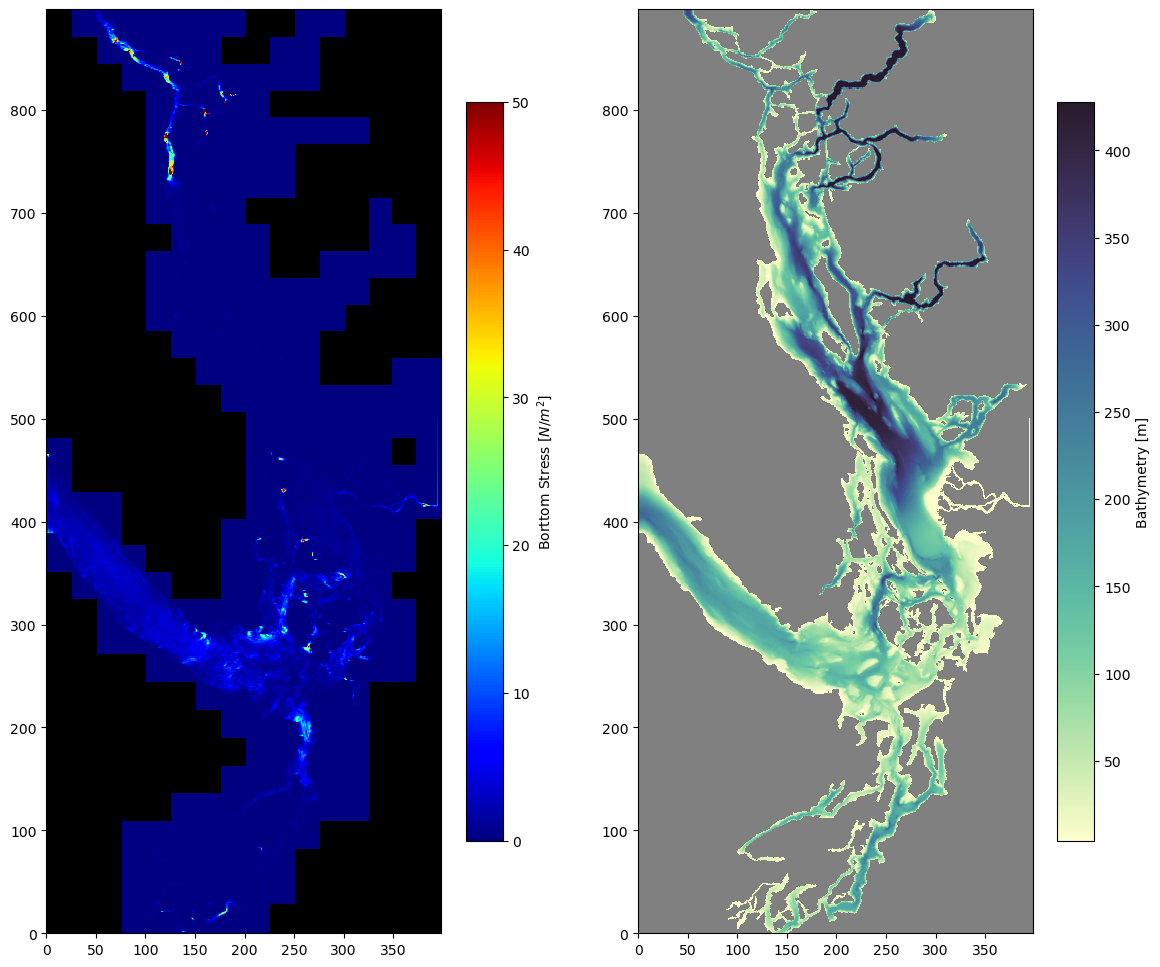

In [12]:
fig, ax = plt.subplots(1,2,figsize = (14,12))
ax[0].pcolormesh(mask[0,:,:], cmap = 'gray')
bs = ax[0].pcolormesh(model['taubot'][0,:,:], cmap=cmap_bs, vmin = 0, vmax = 50)
ax[1].pcolormesh(mask[0,:,:], cmap = 'gray')
bat = ax[1].pcolormesh(bathymetry, cmap=cmap)
cbar = fig.colorbar(bs, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Borttom Stress $[N/m^{2}]$')
#
cbar1 = fig.colorbar(bat, ax=ax[1], location='right', shrink=0.8)
cbar1.set_label('Bathymetry [m]')

Lets see if we can get all the data contained in a single variable:

In [13]:
data_list = []
for i in range(len(files)):
    data = xr.open_dataset(files[i][0])['taubot']
    data_list.append(data)

In [14]:
combined = xr.concat(data_list, dim = 'time_counter')

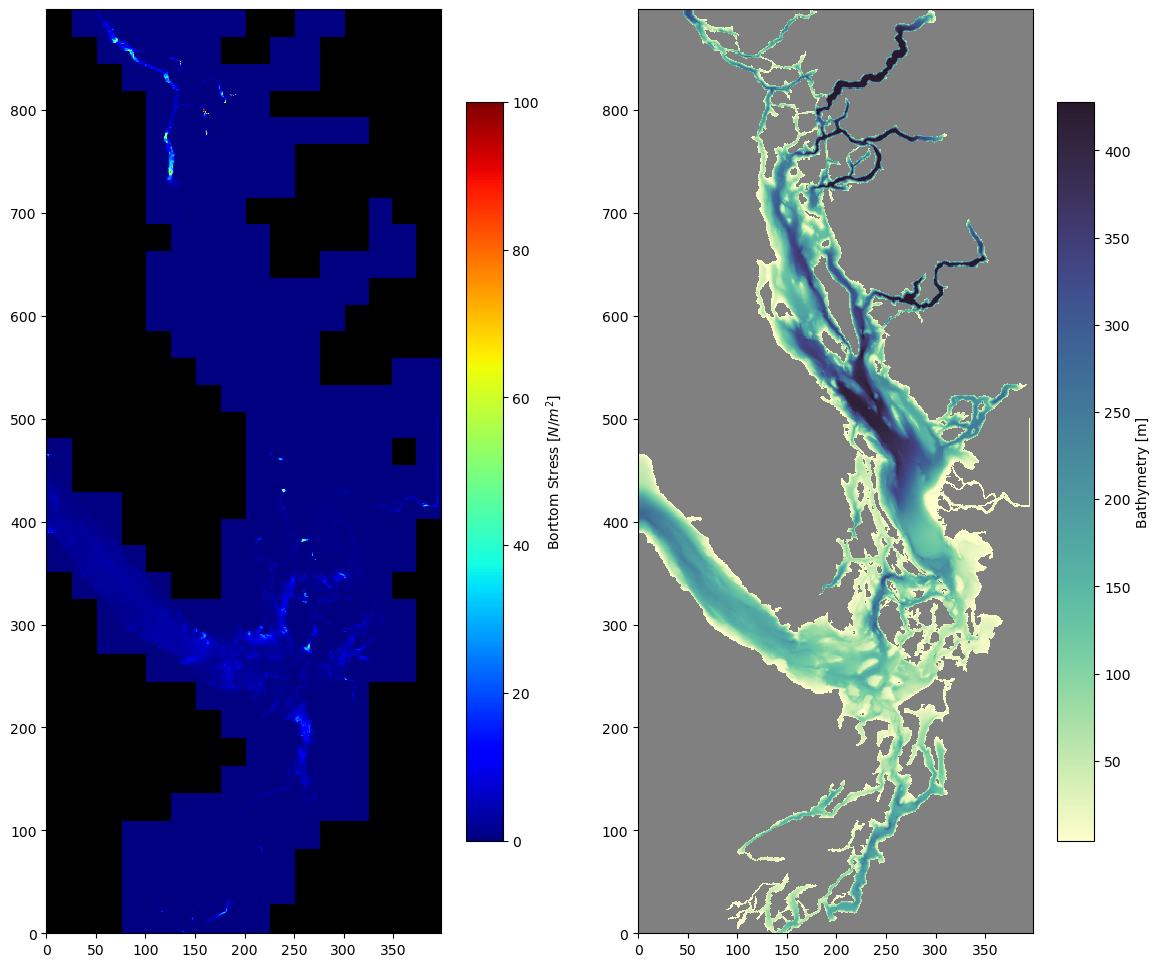

In [15]:
fig, ax = plt.subplots(1,2,figsize = (14,12))
ax[0].pcolormesh(mask[0,:,:], cmap = 'gray')
bs = ax[0].pcolormesh(combined[0,:,:], cmap=cmap_bs, vmin = 0, vmax = 100)
ax[1].pcolormesh(mask[0,:,:], cmap = 'gray')
bat = ax[1].pcolormesh(bathymetry, cmap=cmap)
cbar = fig.colorbar(bs, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Borttom Stress $[N/m^{2}]$')
#
cbar1 = fig.colorbar(bat, ax=ax[1], location='right', shrink=0.8)
cbar1.set_label('Bathymetry [m]')

$$\textbf{Calculating u* from the model}$$

Lets see what we can get from the bottom velocities from the U component in the model.


- Problem to solve:


$$u = \frac{u^{*}}{k} \cdot ln(\frac{z}{z_{*}})$$

We need to get the estimate of the bottom stress ($u^{*}$):

$$u^{*} = \frac{u \cdot k}{ln(\frac{z}{z_{*}})}$$

Where $k = 0.42$, $z_{*} = 0.07 m$ and $z = e3t/2$ 

For $u^{2}$ on the T-grid we need to get the average velocity for each grid cell, as follows:

$u^{2} = \frac{1}{4} (u_{i,j} + u_{i-1,j})^{2} + \frac{1}{4} (v_{i,j} + v_{i, j-1}^2)$

From where we can get the magnitude of this velocity vector as $U = \sqrt{u^{2}}$, for then use the equation above as follows:

$$u^{*} = \frac{U \cdot k}{ln(\frac{z}{z_{*}})}$$

and get an the estimate of $u*$, where $u*^{2} \sim \tau$.


-------------------------------------------------------------------------------------------------------------------------------------------------

Load $\textbf{mbathy}$ and use it as the index of the last "water grid cell"

In [16]:
path_bat = '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc'
bat_file = xr.open_dataset(path_bat)
mbathy = bat_file['mbathy'][0]

Load $\textbf{e3t}$ and $\textbf{vozocrtx}$, which are the grid layer thickness or "cell thickness" and the U component of velocity

In [17]:
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
files_e3t = []
for i in range(t_len):
    files_e3t.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_T.nc'))
    #
files_U = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    #
files_V = []
for i in range(t_len):
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))

Get the velocity data at the right grid point according to mbathy

In [18]:
# function for getting the right grid Z levels for the U velocity
def vel_grid(filename_U_vel, filename_V_vel, filename_e3t, mbathy_array):
    vel_file_U = xr.open_dataset(filename_U_vel)['vozocrtx'][0,:,:,:]
    e3t_file = xr.open_dataset(filename_e3t)['e3t'][0,:,:,:]
    vel_file_V = xr.open_dataset(filename_V_vel)['vomecrty'][0,:,:,:]    
    #
    #z_indices = np.arange(vel_file_U.sizes['depthu'])
    #mask = (z_indices[:, None, None] <= mbathy_array.values -1 ).transpose(0, 1, 2)
    # Create a file of nans, which shares the same dimensions as the velocity one
    #vel_U_corr = xr.full_like(vel_file_U.isel(depthu=0), np.nan)
    #vel_V_corr = xr.full_like(vel_file_V.isel(depthv=0), np.nan)
    #e3t_corr  = xr.full_like(e3t_file.isel(deptht=0), np.nan)
    #
    vel_U_corr = vel_file_U.isel(depthu=mbathy-1)
    vel_V_corr = vel_file_V.isel(depthv=mbathy-1)
    e3t_corr = e3t_file.isel(deptht=mbathy-1)
    #
    ###### U_STAR ######
    z = e3t_corr.copy() / 2
    z_star = 0.07
    k = 0.42
    vel_horizontal = xr.full_like(vel_U_corr, fill_value=np.nan)  
    #
    for j in range(len(vel_file_U['y'])):
        for i in range(len(vel_file_U['x'])):
            U_horizontal_2 = (1/4) * (vel_U_corr[j,i] + vel_U_corr[j,i-1]) ** 2
            V_horizontal_2 = (1/4) * (vel_V_corr[j,i] + vel_V_corr[j-1,i]) ** 2 
            vel_horizontal[j,i] = np.sqrt(U_horizontal_2 + V_horizontal_2)
    #
    # calculation of u-star (u*)
    #
    numerator = vel_horizontal * k 
    denominator = np.log(z/z_star)
    #
    u_star = numerator / denominator
    return vel_U_corr, vel_V_corr, e3t_corr, u_star        

In [19]:
#xr.open_dataset(files_e3t[0][0])['sigma_theta']

In [20]:
aa_u, bb_v, cc_e, U_star = vel_grid(files_U[0][0], files_V[0][0],files_e3t[0][0],mbathy)

In [21]:
#U = (U_star * 2 / (0.42)) * np.log10((cc_e / 2) / 0.07)
#tc = 1000*0.0024*(U**2)

In [22]:
tau = (U_star**2)*1024

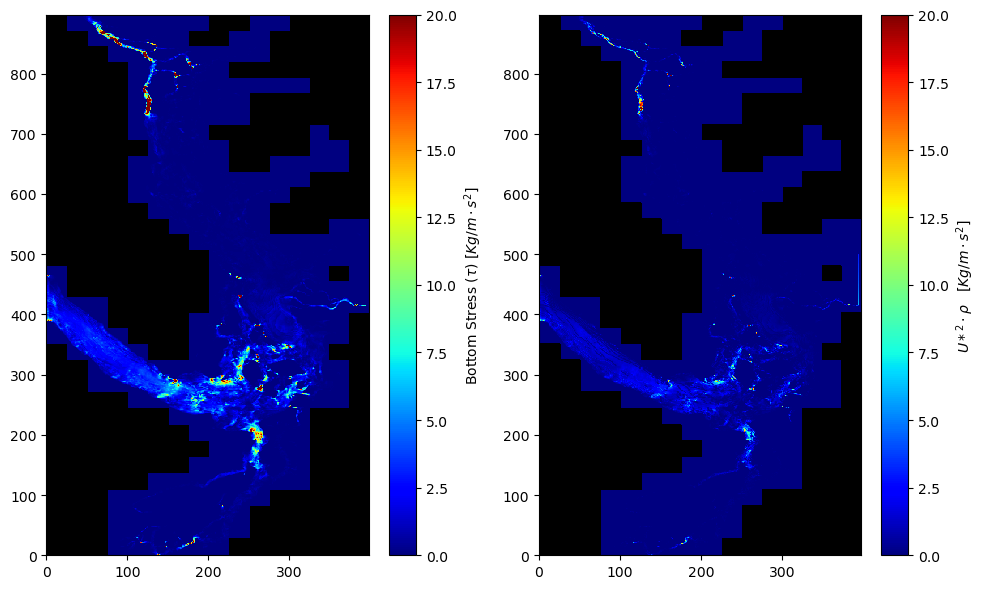

In [23]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].pcolormesh(mask[0], cmap = 'grey')
taubot = ax[0].pcolormesh(model['taubot'][0,:,:], cmap = 'jet', vmin = 0, vmax = 20)
c_taubot = plt.colorbar(taubot, ax = ax[0])
c_taubot.set_label(r'Bottom Stress $(\tau)$ [$Kg/m \cdot s^{2}$]')
#
ax[1].pcolormesh(mask[0], cmap = 'grey')
star = ax[1].pcolormesh(tau, cmap = 'jet', vmin = 0, vmax = 20)
c_star = plt.colorbar(star, ax = ax[1])
c_star.set_label(r'$U*^{2} \cdot  \rho  \ $  [$Kg/m \cdot s^{2}$]')

#
plt.tight_layout()

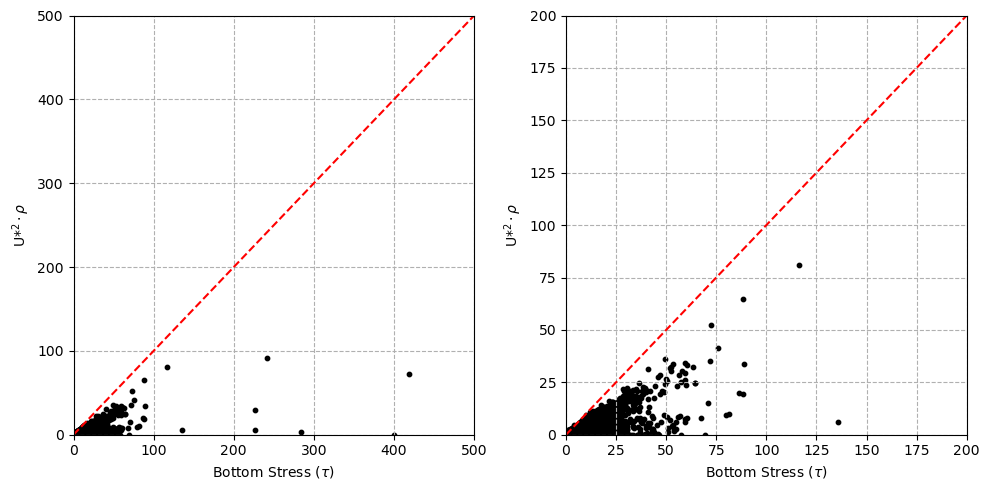

In [24]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].scatter(model['taubot'][0,:,:], tau, c='k', s = 10)
#
ax[0].set_xlabel(r'Bottom Stress ($\tau$)')
ax[0].set_ylabel(r'U*$^{2} \cdot \rho $')
#
ax[0].grid(linestyle = '--')
#
ax[0].set_xlim(0,500)
ax[0].set_ylim(0,500)
#
ax[0].plot([0,500], [0,500], '--r')
#
#
ax[1].scatter(model['taubot'][0,:,:], tau, c='k', s = 10)
#
ax[1].set_xlabel(r'Bottom Stress ($\tau$)')
ax[1].set_ylabel(r'U*$^{2} \cdot \rho $')
#
ax[1].grid(linestyle = '--')
#
ax[1].set_xlim(0,200)
ax[1].set_ylim(0,200)
#
ax[1].plot([0,200], [0,200], '--r')
#
plt.tight_layout()

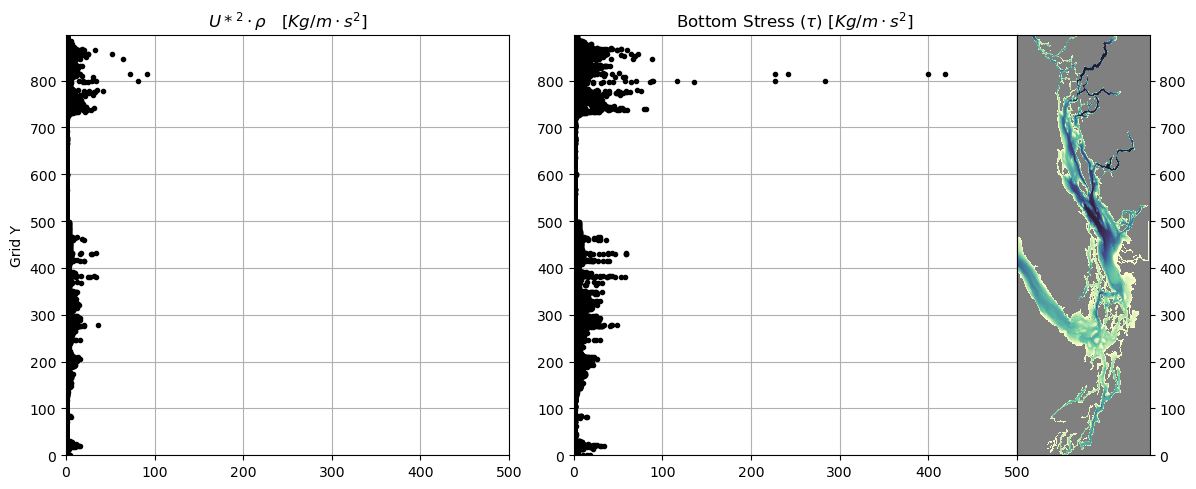

In [25]:
cmap.set_bad('grey')
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(tau, tau['y'], '.k')
ax[0].set_title(r'$U*^{2} \cdot  \rho  \ $  [$Kg/m \cdot s^{2}$]')
ax[0].set_ylabel('Grid Y')
ax[0].set_ylim(0,len(tau['y']))
ax[0].set_xlim(0,500)
ax[0].grid()
#
ax[1].plot(model['taubot'][0],model['y'],'.k')
ax[1].set_title(r'Bottom Stress $(\tau)$ [$Kg/m \cdot s^{2}$]')
ax[1].set_xlim(0,500)
ax[1].set_ylim(0,len(tau['y']))
ax[1].grid()

#
axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
axins1.pcolormesh(bathymetry, cmap=cmap)
axins1.tick_params(which='both',bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False, labelright=True)
axins1.yaxis.tick_right()
#
plt.tight_layout()

SEE HOW IT'S VARYING IN TIME!!

Pick 3 points. One in the southern strait, norhtern strait and near Iona, to see if is there actually some resuspension there...

Now, how can I set a $\textbf{THRESHOLD}$ for my bottom resuspension due to values of $\tau$???

For now lets assume an arbitrary resuspension threshold :)
- This wonderful number will be $\tau _{critical} = 5 [\frac{Kg}{m \ s^{2}}]$

In [106]:
t_critical = 1

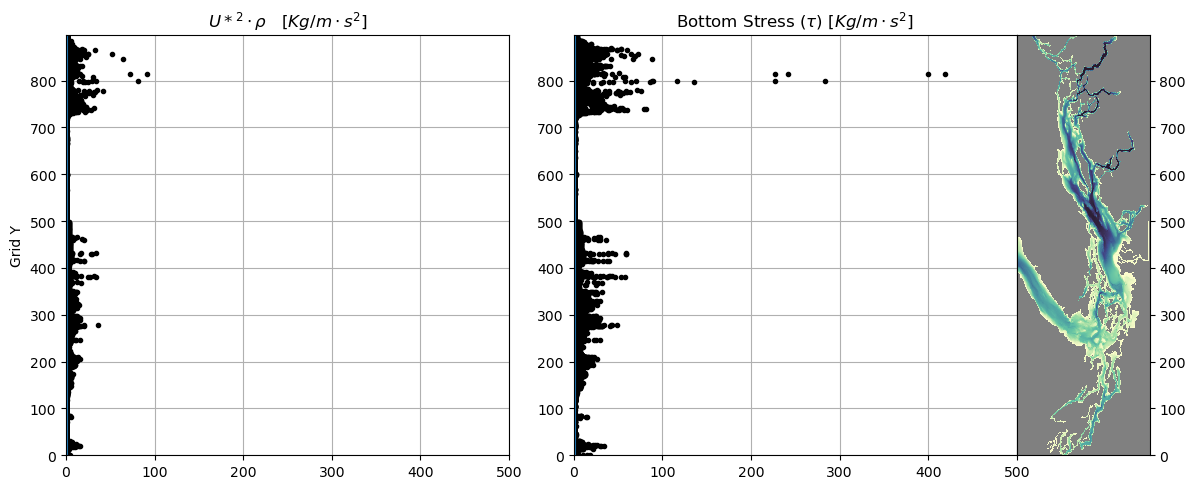

In [107]:
cmap.set_bad('grey')
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(tau, tau['y'], '.k')
ax[0].set_title(r'$U*^{2} \cdot  \rho  \ $  [$Kg/m \cdot s^{2}$]')
ax[0].set_ylabel('Grid Y')
ax[0].set_ylim(0,len(tau['y']))
ax[0].set_xlim(0,500)
ax[0].grid()
ax[0].vlines(x = t_critical, ymin = 0, ymax = len(tau['y']))
#
ax[1].plot(model['taubot'][0],model['y'],'.k')
ax[1].set_title(r'Bottom Stress $(\tau)$ [$Kg/m \cdot s^{2}$]')
ax[1].set_xlim(0,500)
ax[1].set_ylim(0,len(tau['y']))
ax[1].grid()
ax[1].vlines(x = t_critical, ymin = 0, ymax = len(tau['y']))

#
axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
axins1.pcolormesh(bathymetry, cmap=cmap)
axins1.tick_params(which='both',bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False, labelright=True)
axins1.yaxis.tick_right()
#
plt.tight_layout()

In [108]:
tau_res = tau.where(tau>t_critical)
taubot_res = model['taubot'][0].where(model['taubot'][0]>t_critical)

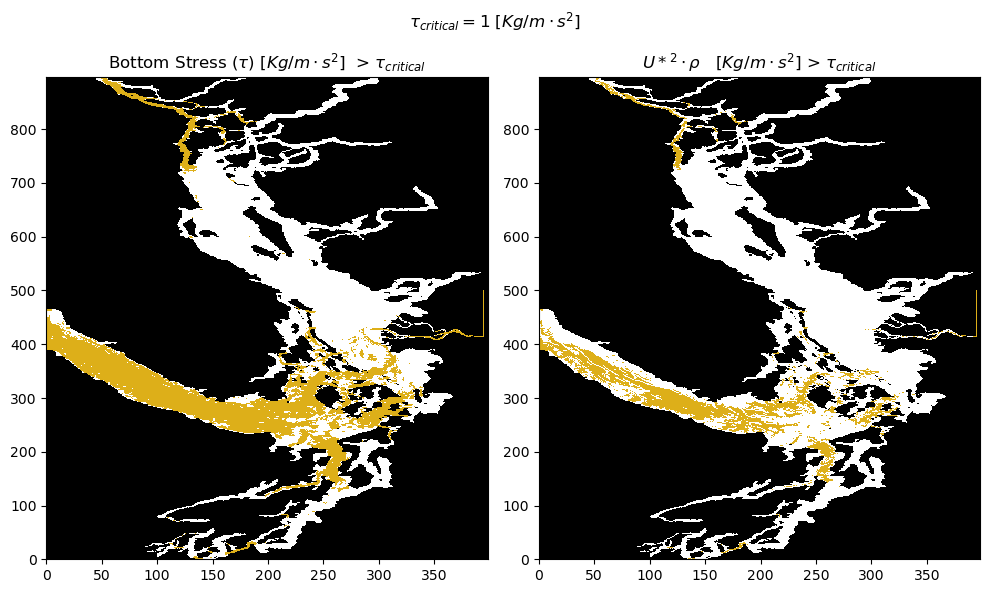

In [109]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].pcolormesh(mask[0], cmap = 'grey')
taa_bot = ax[0].pcolormesh(taubot_res, cmap = cmocean.cm.oxy, vmin = 0, vmax = 0.01)
#c_taubot = plt.colorbar(taa_bot, ax = ax[0])
ax[0].set_title(r'Bottom Stress $(\tau)$ [$Kg/m \cdot s^{2}$]  > $\tau _{critical}$')
#
ax[1].pcolormesh(mask[0], cmap = 'grey')
star = ax[1].pcolormesh(tau_res, cmap = cmocean.cm.oxy, vmin = 0, vmax = 0.01)
#c_star = plt.colorbar(star, ax = ax[1])
ax[1].set_title(r'$U*^{2} \cdot  \rho  \ $  [$Kg/m \cdot s^{2}$] > $\tau _{critical}$')
#
plt.suptitle(r'$\tau _{critical} =  $' + str(t_critical) + r' [$Kg/m \cdot s^{2}$]')
plt.tight_layout()

Should this depend on Grain Size and Sediment Density?

$\tau _{cr} = \tau _{ci} \cdot g(\rho _{sediment} - \rho _{water}) * d_{particle \ size} \ : [\frac{Kg}{m \ s^{2}}]$

link : https://dec.vermont.gov/sites/dec/files/wsm/rivers/docs/assessment-protocol-appendices/O-Appendix-O-04-Shear-Stress.pdf#:~:text=Critical%20shear%20stress%20is%20the%20shear%20stress%20required,critical%20shear%20stress%2C%20channel%20degradation%20will%20likely%20result.

In [30]:
g_d = 1250 # approx for gravel
t_ci = 0.06
d_p = 31 * (10**(-6)) # in micro m
t_threshold = t_ci * 10 * (g_d - 1024) * d_p

In [31]:
t_threshold

0.0042036

Threshold curve based on: https://search.informit.org/doi/epdf/10.3316/informit.929741720399033

Threshold of motion by currents:

- $\theta _{cr} = \frac{0.24}{D*} + 0.055 \cdot [1 - exp(-0.020 \cdot D*)]$

Modified version:
- $\theta _{cr} = \frac{0.30}{1 + 1.2 \cdot D*} + 0.055 \cdot [1 - exp(-0.020 \cdot D*)]$

In [32]:
f_sediments_1 = (0.24 / d_p) + 0.055*(1 - np.exp(-0.020*d_p)) 
f_sediments_2 = (0.30 / (1 + 1.2*d_p)) + 0.055*(1 - np.exp(-0.020*d_p)) 

In [33]:
print(r'threshold f1: ', f_sediments_1)
print('Este esta malisimo')
print(r'threshold f2: ', f_sediments_2)
print('this one looks better')

threshold f1:  7741.935483905067
Este esta malisimo
threshold f2:  0.299988874515126
this one looks better


In [34]:
size = np.arange(1,1000)
formula_sediments_1 = (0.24 / size) + 0.055*(1 - np.exp(-0.020*size)) 
formula_sediments_2 = (0.30 / (1 + 1.2*size)) + 0.055*(1 - np.exp(-0.020*size)) 

Text(0, 0.5, '$\\theta _{cr}$')

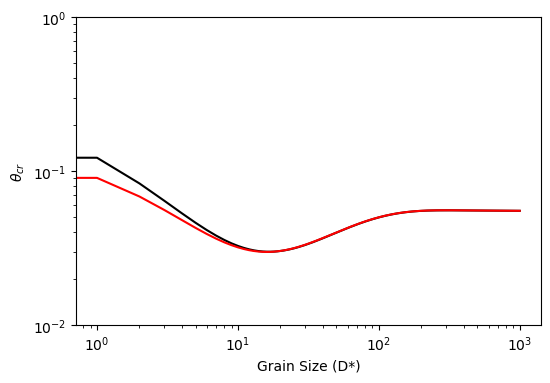

In [35]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(formula_sediments_1, 'k')
ax.plot(formula_sediments_2, 'r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.01,1)
ax.set_xlabel('Grain Size (D*)')
ax.set_ylabel(r'$\theta _{cr}$')


In [36]:
#d_size = 31
#rho_grain = 1300
#eq_threshold = np.divide(tau, (10 * (rho_grain - 1000)*(d_size*(10**(-6)))))

$$\textbf{Now, lets see how is varying in time!!}$$

Load the necessary data from specified grid points:

In [37]:
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

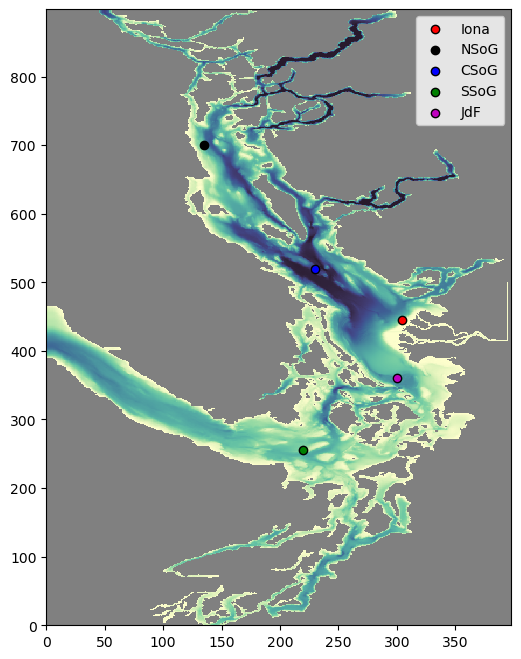

In [110]:
a, b = finder(49.195045, -123.301956) # location close to Iona Outfall in lat and lon coordinates
a1, b1 = 700, 135 # location at northern strait in grid points
a2, b2 = 520, 230# location at southern strait in grid points
a3, b3 = 255, 220 # location at the strait of JdF in grid points
a4, b4 = 360, 300 # location at the strait of JdF in grid points

############################ visualize points in the map #############################
fig, ax = plt.subplots(figsize = (6,8))
ax.pcolormesh(bathymetry, cmap=cmap)
ax.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
ax.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
ax.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
ax.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
ax.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
ax.legend()

In [39]:
regions = ['Iona', 'NSoG', 'CSoG', 'SSoG', 'JdF']
colors = ['r', 'k', 'b', 'g', 'm']

The taubot data files are from August 06, 2015 to March 10, 2016. Lets select 4 days!!

In [40]:
begin = datetime(2015,8,6)
end = datetime(2015,8,10)
#end = datetime(2016,3,10)
t_len = (end - begin).days # length of 4 days
#
dates = get_timestamps(begin,t_len)

In [41]:
hourly_dates = pd.date_range(start=begin, end=end, freq='H')[:-1]

In [42]:
files = []
for i in range(t_len):
    files.append(date_files(dates[i][0],path))

In [43]:
def get_taubot_series(files_input, y_coordinate, x_coordinate, dimension = 'time_counter', variable = 'taubot'):
    #    
    data_list = []
    for i in range(len(files_input)):
        data = xr.open_dataset(files_input[i][0])[variable][:,y_coordinate, x_coordinate]
        data_list.append(data)
    #
    data_series = xr.concat(data_list, dim = dimension)    
    return data_series    

In [44]:
############# taubot data for 4 days ############# 
taubot_days = np.array([get_taubot_series(files,a,b).values, get_taubot_series(files,a1,b1).values, get_taubot_series(files,a2,b2).values,get_taubot_series(files,a3,b3).values, get_taubot_series(files,a4,b4).values]).T

Text(0, 0.5, 'Model Bottom Stress (Taubot) [$Kg \\cdot m^{-1} \\cdot s^{-2}$]')

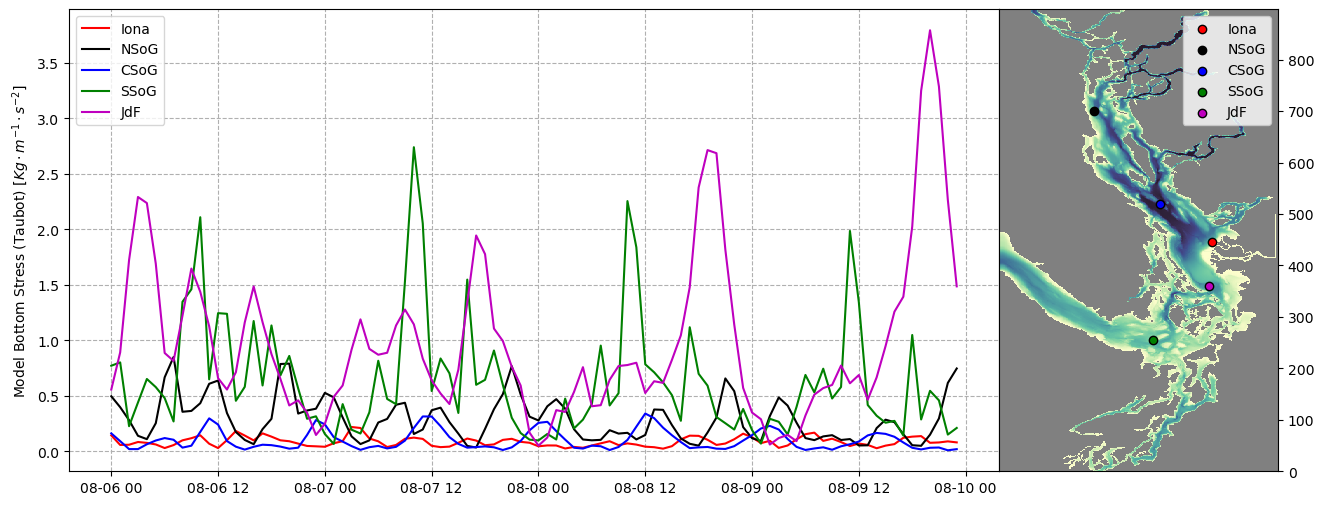

In [46]:
fig, ax = plt.subplots(figsize = (12,6))
for n in range(len(regions)):
    ax.plot(hourly_dates, taubot_days[:,n], color = colors[n] ,label = regions[n])
    ax.legend()
axins = ax.inset_axes([1, 0, 0.3, 1])
axins.pcolormesh(bathymetry, cmap=cmap)
axins.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
axins.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
axins.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
axins.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
axins.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
axins.legend()
axins.tick_params(which='both',bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False, labelright=True)
#
ax.grid(linestyle = '--')
ax.set_ylabel(r'Model Bottom Stress (Taubot) [$Kg \cdot m^{-1} \cdot s^{-2}$]')    

In [47]:
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
files_e3t = []
for i in range(t_len):
    files_e3t.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_T.nc'))
    #
files_U = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    #
files_V = []
for i in range(t_len):
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))

In [48]:
# function for getting the right grid Z levels for the U velocity
def u_star_series(file_U_vel, file_V_vel, file_e3t, y_coor, x_coor, dimension = 'time_counter'):
    u_star_data = []
    for n in range(len(file_e3t)):
        vel_U = xr.open_dataset(file_U_vel[n][0])['vozocrtx'][:,mbathy[y_coor,x_coor]-1,:,:]
        e3t = xr.open_dataset(file_e3t[n][0])['e3t'][:,mbathy[y_coor,x_coor]-1,:,:]
        vel_V = xr.open_dataset(file_V_vel[n][0])['vomecrty'][:,mbathy[y_coor,x_coor]-1,:,:]    
        #
        ###### U_STAR ######
        z = e3t.copy() / 2
        z_star = 0.07
        k = 0.42
        vel_horizontal = xr.full_like(vel_U[:,y_coor,x_coor], np.nan)  
        #
        
        U_horizontal_2 = (1/4) * (vel_U[:,y_coor,x_coor] + vel_U[:,y_coor,x_coor-1]) ** 2
        V_horizontal_2 = (1/4) * (vel_V[:,y_coor,x_coor] + vel_V[:,y_coor-1,x_coor]) ** 2 
        vel_horizontal = np.sqrt(U_horizontal_2 + V_horizontal_2)
    #
        # calculation of u-star (u*)
        #
        numerator = vel_horizontal * k 
        denominator = np.log(z[:,a,b]/z_star)
        #
        u_star = ((numerator / denominator) ** 2) * 1024
        u_star_data.append(u_star)
    u_star_series = xr.concat(u_star_data, dim = dimension)
    return u_star_series   

In [49]:
############# calculated U_star data for 4 days ############# 
U_star_days = np.array([u_star_series(files_U, files_V, files_e3t, a, b).values, u_star_series(files_U, files_V, files_e3t, a1, b1).values, u_star_series(files_U, files_V, files_e3t, a2, b2).values, u_star_series(files_U, files_V, files_e3t, a3, b3).values, u_star_series(files_U, files_V, files_e3t, a4, b4).values]).T

Text(0, 0.5, 'Calculated Bottom Stress ($U^{*2} \\cdot \\rho$) [$Kg \\cdot m^{-1} \\cdot s^{-2}$]')

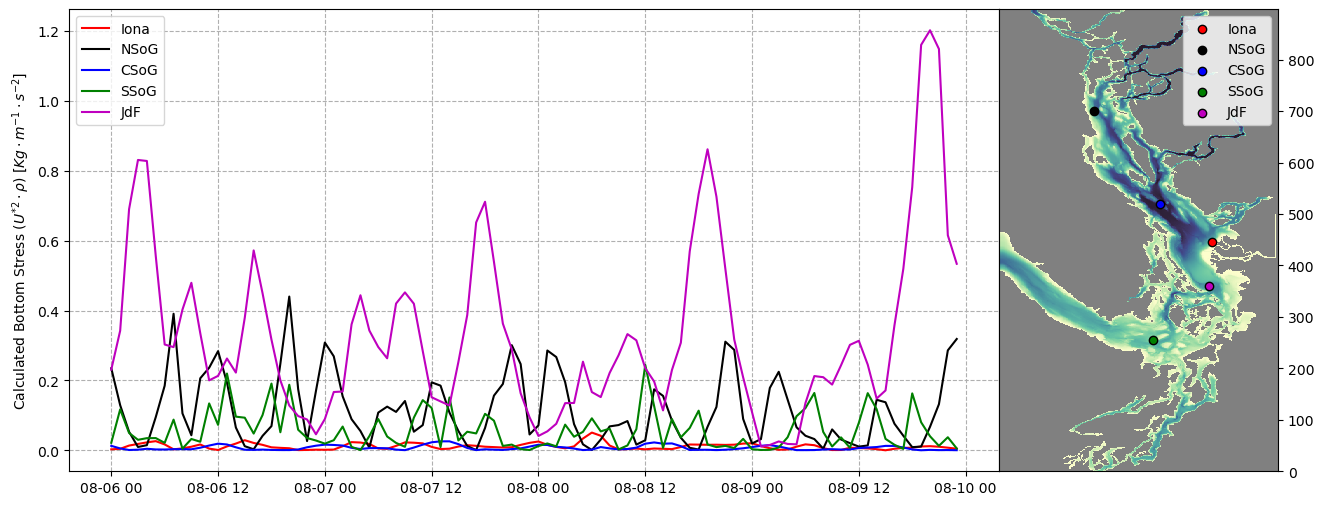

In [50]:
fig, ax = plt.subplots(figsize = (12,6))
for n in range(len(regions)):
    ax.plot(hourly_dates, U_star_days[:,n], color = colors[n] ,label = regions[n])
    ax.legend()
axins = ax.inset_axes([1, 0, 0.3, 1])
axins.pcolormesh(bathymetry, cmap=cmap)
axins.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
axins.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
axins.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
axins.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
axins.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
axins.legend()
axins.tick_params(which='both',bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False, labelright=True)
#
ax.grid(linestyle = '--')
ax.set_ylabel(r'Calculated Bottom Stress ($U^{*2} \cdot \rho$) [$Kg \cdot m^{-1} \cdot s^{-2}$]') 

In [87]:
B = [b, b1, b2 ,b3 ,b4]
A = [a, a1, a2 ,a3 ,a4]

Look at their correlation:

In [95]:
correlations = np.zeros(len(taubot_days[0,:]))
for i in range(len(correlations)):
    correlations[i] = np.corrcoef(taubot_days[:,i], U_star_days[:,i])[0][1]
corr = np.round(correlations,3).astype(str)    

Compare the different time series between the two:

/tmp/ipykernel_1087502/800993786.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


Text(112.59722222222221, 0.5, '$\\tau$  [$Kg \\cdot m^{-1} \\cdot s^{-2}$]')

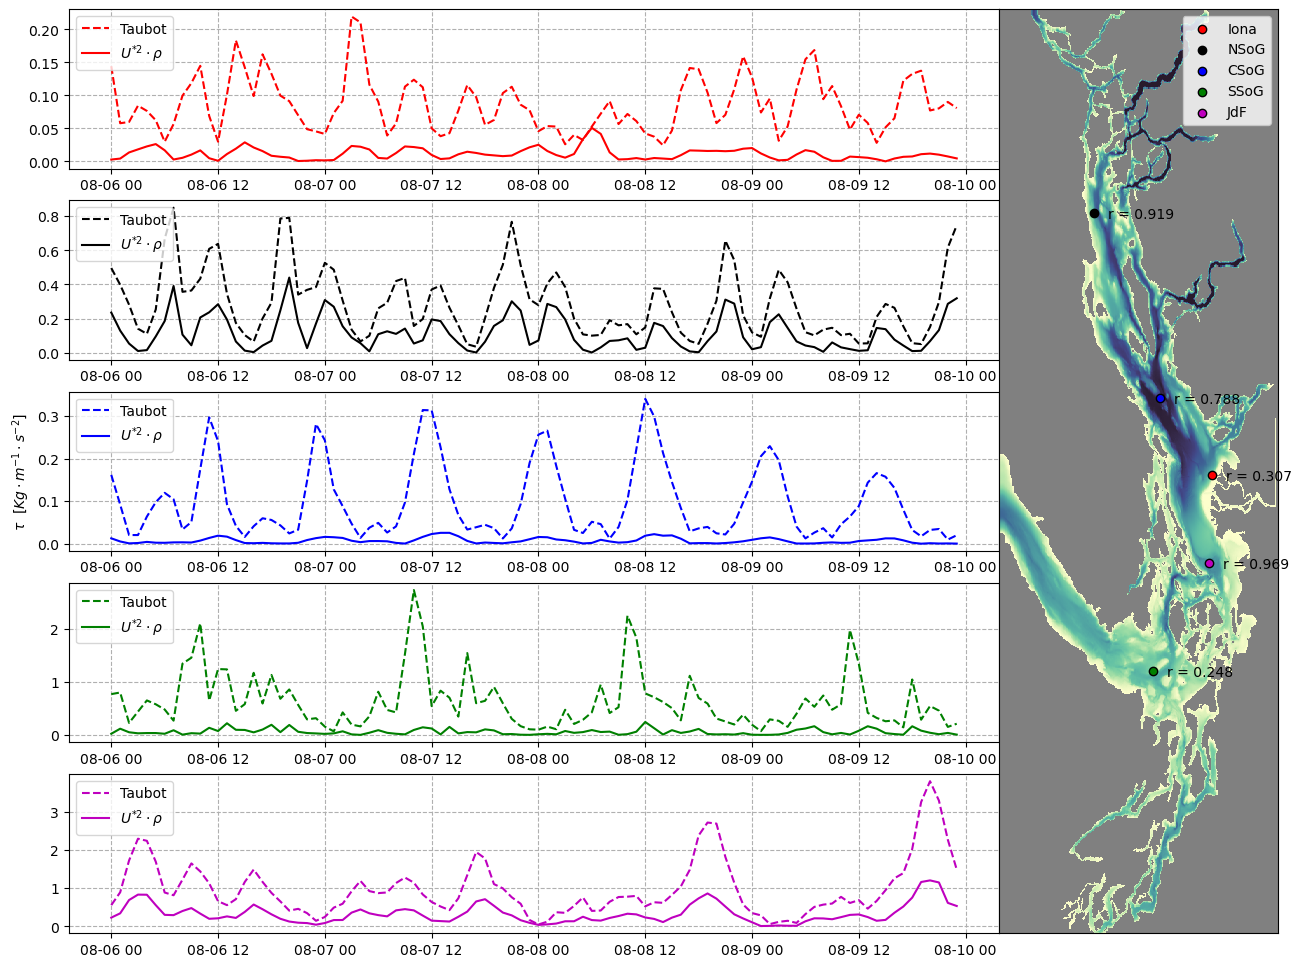

In [101]:
fig, ax = plt.subplots(5,figsize = (12,12))
for n in range(len(regions)):
    ax[n].plot(hourly_dates, taubot_days[:,n], '--', color = colors[n] ,label = 'Taubot')
    ax[n].plot(hourly_dates, U_star_days[:,n], color = colors[n] ,label = r'$U^{*2} \cdot \rho$')
    ax[n].legend(loc = 'upper left')
    ax[n].grid(linestyle = '--')

axins = ax[4].inset_axes([1, 0, 0.3, 5.8])
axins.pcolormesh(bathymetry, cmap=cmap)
axins.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
axins.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
axins.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
axins.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
axins.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
axins.legend()
axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False, labelright=False)
#
for i, txt in enumerate(corr):
    axins.annotate('r = '+txt, (B[i] + 20, A[i] - 5)) 
#
plt.tight_layout()
ax[2].set_ylabel(r'$\tau$  [$Kg \cdot m^{-1} \cdot s^{-2}$]') 